#### Chapter1 코드정리

=== 전체 모델 성능 비교 ===
                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.694805   0.574468  0.500000  0.534653
1           KNN (k=20)  0.753247   0.700000  0.518519  0.595745
2            SVM (RBF)  0.714286   0.613636  0.500000  0.551020
3        Decision Tree  0.746753   0.659574  0.574074  0.613861
4        Random Forest  0.740260   0.659091  0.537037  0.591837
5    Gradient Boosting  0.733766   0.632653  0.574074  0.601942


'\n# -------------------------------------------------------\n# 7. ROC Curve 출력\n# -------------------------------------------------------\nplt.plot([0,1], [0,1], \'k--\', label="Random Guess")\nplt.xlabel("False Positive Rate")\nplt.ylabel("True Positive Rate")\nplt.title("ROC Curve Comparison (All Models)")\nplt.legend()\nplt.grid()\nplt.show()\n'

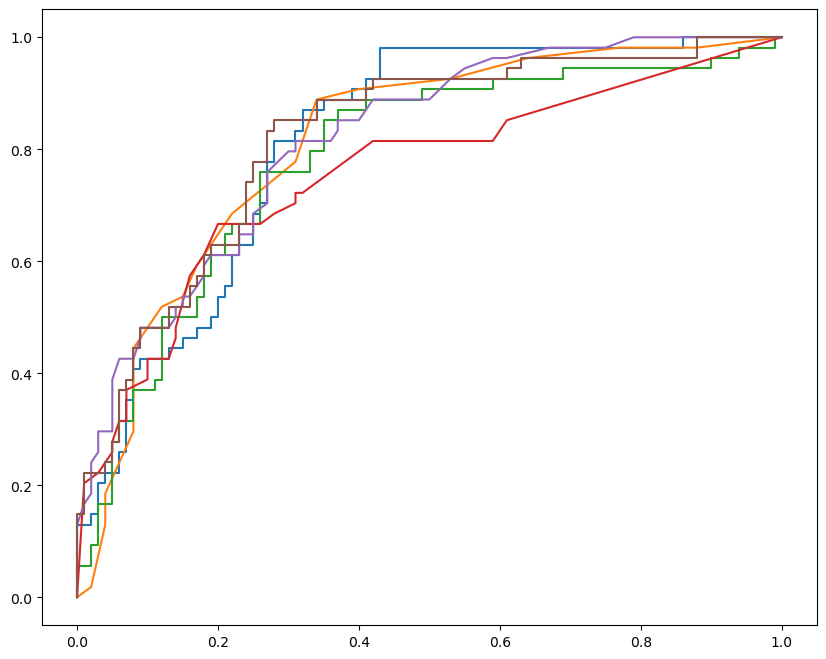

In [19]:
# 라이브러기 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc)

# 모델들
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# -------------------------------------------------------
# 1. 데이터 불러오기
# -------------------------------------------------------
df = pd.read_csv("diabetes_median.csv")

# X, y 분리
X = df.drop(["Outcome", "SkinThickness","Age"], axis=1)
y = df["Outcome"]

# -------------------------------------------------------
# 2. Train / Test split
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# -------------------------------------------------------
# 3. 스케일링 (Logistic / KNN / SVM / LinearRegression)
# -------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------------------------------
# 4. 사용할 모델 목록
# -------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),

    # KNN 수정: model__ 제거 + 문자열 사용
    "KNN (k=20)": KNeighborsClassifier(
        metric="minkowski",
        n_neighbors=20,
        weights="uniform"
    ),

    # SVM 수정: model__ 제거
    "SVM (RBF)": SVC(
        #gamma=np.float64(0.007742636826811269),
        #C=np.float64(12.915496650148826),
        kernel='rbf',
        probability=True
    ),

    # Decision Tree 수정: 파라미터 이름 오타 수정
    "Decision Tree": DecisionTreeClassifier(
        max_depth=7,
        max_features='log2',
        min_samples_leaf=4,
        min_samples_split=20,
        random_state=42
    ),

    # Random Forest 수정: 파라미터 이름 + 문자열 수정
    "Random Forest": RandomForestClassifier(
        #max_depth=5,
        #max_features='log2',
        #min_samples_leaf=2,
        #min_samples_split=10,
        n_estimators=100,
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        #learning_rate=0.1,
        #max_depth=2,
        #n_estimators=50,
        #subsample=0.6,
        random_state=42
    )
}

results = []  # 성능표 저장

plt.figure(figsize=(10, 8))

# -------------------------------------------------------
# 5. 모델 학습 + 평가 + ROC Curve/AUC 계산
# -------------------------------------------------------
for name, model in models.items():

    # 스케일 사용할 모델
    if name in ["Logistic Regression", "KNN (k=20)", "SVM (RBF)"]:
        model.fit(X_train_scaled, y_train)
        # Linear Regression은 연속값 → threshold 0.5로 분류
        if name == "Linear Regression":
            y_prob = model.predict(X_test_scaled)
            y_pred = (y_prob >= 0.5).astype(int)
        else:
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # 트리 기반 모델
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    # 성능 계산
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

# -------------------------------------------------------
# 6. 성능표 출력
# -------------------------------------------------------
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)
print("=== 전체 모델 성능 비교 ===")
print(results_df)


results_df.to_csv("median_accuracy_woSandA.csv", index=False)

'''
# -------------------------------------------------------
# 7. ROC Curve 출력
# -------------------------------------------------------
plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (All Models)")
plt.legend()
plt.grid()
plt.show()
'''


In [3]:
# 실제 튜닝 코드 예시 (Pipeline + GridSearchCV)
# 전처리+모델묶기
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# train / test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
# 로지스틱 회귀 튜닝 예시
from sklearn.linear_model import LogisticRegression

pipe_log = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

param_grid_log = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

grid_log = GridSearchCV(
    estimator=pipe_log,
    param_grid=param_grid_log,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_log.fit(X_train, y_train)

print("Logistic Regression 최적 파라미터:", grid_log.best_params_)
print("교차검증 최고 AUC:", grid_log.best_score_)
best_log = grid_log.best_estimator_


Logistic Regression 최적 파라미터: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
교차검증 최고 AUC: 0.8436281838316722


In [5]:
# KNN 튜닝 예시
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

param_grid_knn = {
    'model__n_neighbors': list(range(1, 31)),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['minkowski', 'manhattan']
}

grid_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

print("KNN 최적 파라미터:", grid_knn.best_params_)
print("KNN 최고 AUC:", grid_knn.best_score_)
best_knn = grid_knn.best_estimator_


KNN 최적 파라미터: {'model__metric': 'minkowski', 'model__n_neighbors': 21, 'model__weights': 'uniform'}
KNN 최고 AUC: 0.8378993632336655


In [6]:
# SVM (RBF) 튜닝 예시 (RandomizedSearchCV)

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='rbf', probability=True))
])

param_dist_svm = {
    'model__C': np.logspace(-2, 2, 10),      # 0.01 ~ 100
    'model__gamma': np.logspace(-3, 1, 10)   # 0.001 ~ 10
}

random_svm = RandomizedSearchCV(
    estimator=pipe_svm,
    param_distributions=param_dist_svm,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_svm.fit(X_train, y_train)

print("SVM 최적 파라미터:", random_svm.best_params_)
print("SVM 최고 AUC:", random_svm.best_score_)
best_svm = random_svm.best_estimator_

SVM 최적 파라미터: {'model__gamma': np.float64(0.021544346900318832), 'model__C': np.float64(1.6681005372000592)}
SVM 최고 AUC: 0.8441486710963455


In [7]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

param_grid_tree = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_tree.fit(X_train, y_train)

print("Decision Tree 최적 파라미터:", grid_tree.best_params_)

Decision Tree 최적 파라미터: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 20}


In [8]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Random Forest 최적 파라미터:", grid_rf.best_params_)

Random Forest 최적 파라미터: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [9]:
# Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8, 1.0]
}

grid_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_gb.fit(X_train, y_train)

print("Gradient Boosting 최적 파라미터:", grid_gb.best_params_)



Gradient Boosting 최적 파라미터: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.6}
